In [2]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [3]:
### READ AND SAVE MAP COORDINATES OF SCATS SITES
df_raw = pd.read_csv("data.csv", skiprows=1, encoding='utf-8').fillna(0)
df_raw = df_raw[['SCATS Number', 'NB_LATITUDE', 'NB_LONGITUDE']]
df_raw = df_raw.drop_duplicates(subset=['SCATS Number'], keep='first')
df_raw.to_csv("map/coordinates.csv", index=False)

In [4]:
### READ TIME SERIES DATA
df_raw = pd.read_csv("data.csv", skiprows=1, encoding='utf-8').fillna(0)
df_raw = df_raw.drop(columns=['CD_MELWAY', 'NB_LATITUDE', 'NB_LONGITUDE', 'HF VicRoads Internal', 'VR Internal Stat',	'VR Internal Loc', 'NB_TYPE_SURVEY', 'Unnamed: 106', 'Unnamed: 107', 'Unnamed: 108'])
print(df_raw.head())

   SCATS Number                         Location       Date  V00  V01  V02  \
0           970  WARRIGAL_RD N of HIGH STREET_RD  1/10/2006   86   83   52   
1           970  WARRIGAL_RD N of HIGH STREET_RD  2/10/2006   32   28   17   
2           970  WARRIGAL_RD N of HIGH STREET_RD  3/10/2006   26   32   21   
3           970  WARRIGAL_RD N of HIGH STREET_RD  4/10/2006   32   22   28   
4           970  WARRIGAL_RD N of HIGH STREET_RD  5/10/2006   40   39   21   

   V03  V04  V05  V06  ...  V86  V87  V88  V89  V90  V91  V92  V93  V94  V95  
0   58   59   44   31  ...  114   97   97   66   81   50   59   47   29   34  
1   11    7   11    6  ...  111  102  107  114   80   60   62   48   44   26  
2   14   10   12   13  ...  130  132  114   86   93   90   73   57   29   40  
3   13   16    8   14  ...  115  113  132  101  113   90   78   66   52   44  
4   11   16    9   15  ...  171  120  116  113   99   91   61   55   49   36  

[5 rows x 99 columns]


In [5]:
### PROCESS DATA
# Make sure for 1 location, in 1 day, there are only 1 time series
df = df_raw.drop_duplicates(subset=['Location', 'Date'], keep='first')

# Drop locations without data on 31/10/2006(which is also the locations with less days recorded)
values_with_date = df[df['Date'] == '31/10/2006']['Location'].unique()
values_without_date = df[~df['Location'].isin(values_with_date)]['Location'].unique()
print(values_without_date)
df.drop(df[df['Location'].isin(values_without_date)].index, inplace=True)
print(df['Location'].value_counts())

scat_dfs = [group for _, group in df.groupby('SCATS Number')]


['CHURCH_ST SW of BARKERS_RD' 'WARRIGAL_RD S of HIGHBURY_RD'
 'GLENFERRIE_RD S of BURWOOD_RD']
Location
WARRIGAL_RD N of HIGH STREET_RD    31
BALWYN_RD N OF BELMORE_RD          31
SEVERN_ST S of DONCASTER_RD        31
DONCASTER_RD E of BULLEEN_RD       31
TOORAK_RD W OF BURKE_RD            31
                                   ..
BRIDGE_RD SW of BURWOOD_RD         26
POWER_ST N of BURWOOD_RD           26
BURWOOD_RD E of POWER_ST           26
CANTERBURY_RD W of BALWYN_RD       26
DENMARK_ST N of BARKERS_RD         26
Name: count, Length: 136, dtype: int64


In [6]:
# Create a python dict mapping scat site numbers to an array of traffic flow

scat_to_ts = {}
for scat_df in scat_dfs:
  # Get time series for each side of the intersection. ts is a pandas series, indexes are location names, values are the time series of that location
  ts = scat_df.groupby('Location').apply(lambda x: x.drop(columns=['SCATS Number', 'Location', 'Date']).values.flatten().tolist())

  # Get scat number
  scat = scat_df['SCATS Number'].values[0]

  # Truncate so that everyside of the intersection has the same time series length
  min_total_observation = min(ts.map(len).values)
  truncated_ts = [arr[-min_total_observation:] for arr in ts.values]

  # Get intersection flow by getting the average of the time series of all sides (this must be take into consideration later, since an intersection with more sides is likely to have more traffic, maybe add the values instead of averaging)
  average_ts = np.mean(truncated_ts, axis=0)
  scat_to_ts[scat] = average_ts

print(scat_to_ts)
   

{970: array([30.  , 24.75, 17.75, ..., 39.5 , 39.5 , 33.25]), 2000: array([62. , 52.5, 45. , ..., 65. , 51.5, 47. ]), 2200: array([36.5 , 32.25, 28.75, ..., 27.25, 17.  , 14.  ]), 2820: array([45. , 40. , 41. , ..., 39.5, 37.5, 29. ]), 2825: array([61., 83., 55., ..., 47., 38., 41.]), 2827: array([72.25, 68.75, 63.25, ..., 47.5 , 40.75, 35.25]), 2846: array([44.25, 30.25, 29.25, ..., 18.75, 19.5 , 14.25]), 3001: array([84.66666667, 76.66666667, 72.        , ..., 42.66666667,
       71.        , 60.33333333]), 3002: array([58.5 , 70.25, 57.75, ..., 42.25, 40.25, 33.25]), 3120: array([81.  , 82.25, 80.  , ..., 58.5 , 58.  , 50.75]), 3122: array([45.33333333, 40.33333333, 40.        , ..., 27.33333333,
       29.66666667, 24.33333333]), 3126: array([69.33333333, 60.66666667, 66.        , ..., 46.        ,
       35.66666667, 36.        ]), 3127: array([45.66666667, 47.66666667, 48.        , ..., 35.        ,
       28.        , 25.66666667]), 3180: array([26.        , 32.33333333, 26.6666

In [ ]:
##### Write Processed Time series data to csv file, only run once#####
"""
import csv
with open("time_series.csv", mode='w', newline='') as file:
  writer = csv.writer(file)

  for key, value in scat_to_ts.items():
    temp = []
    temp.append(key)
    temp.extend(value)
    print(temp)
    writer.writerow(temp)
"""

In [ ]:
import joblib
# Normalize the time series
scalers = {}
for scat in scat_to_ts:
  scaler = MinMaxScaler()
  scat_to_ts[scat] = np.array(scat_to_ts[scat]).reshape(-1, 1)
  scat_to_ts[scat] = scaler.fit_transform(scat_to_ts[scat]).ravel()
  scalers[scat] = scaler

  ### Save the scalers
  #joblib.dump(scaler, f'scaler_{scat}.pkl')

print(scat_to_ts)

In [9]:
### TRAIN MODELS
from model import get_lstm, get_gru, train_saes_2, get_tcn

### Function to prepare data for training and testing
def split_data(flow, lags):
  # Split data for 1 scat
  # flow: array of flow every 15 mins
  split_index = int(len(flow) * 0.8)  # 80% for training, 20% for testing

  train_data = np.array(flow[:split_index])
  test_data = np.array(flow[split_index:])
  
  train, test = [], []

  for i in range(lags, len(train_data)):
    train.append(train_data[i - lags: i + 1])
  for i in range(lags, len(test_data)):
    test.append(test_data[i - lags: i + 1])

  train = np.array(train)
  test = np.array(test)
  np.random.shuffle(train)

  X_train = train[:, :-1]
  y_train = train[:, -1]
  X_test = test[:, :-1]
  y_test = test[:, -1]

  return X_train, y_train, X_test, y_test

result = {}

X_trains, y_trains, X_tests, y_tests = {}, {}, {}, {}




############################## TRAIN LSTM MODELS & TEST ##############################
"""
for scat in scat_to_ts:
  # Split data for each scat
  flow = scat_to_ts[scat]

  # Set 12 or 96 lags
  lags = 12
  X_trains[scat], y_trains[scat], X_tests[scat], y_tests[scat] = split_data(flow, lags)

  # Get LSTM model
  input_dim = len(flow)
  lstm = get_lstm((lags, 1))

  lstm.compile(loss='mean_squared_error', optimizer='rmsprop')
  lstm.fit(X_trains[scat], y_trains[scat], epochs=50, batch_size=32)
  lstm.save(f"models/v1/lstm/{scat}.h5")
  
  y_pred = lstm.predict(X_tests[scat])
  result[scat] = lstm.evaluate(X_tests[scat], y_tests[scat])
"""


############################## LOAD LSTM MODELS & TEST ##############################
"""
scaled_result = {}
scaled_true = {}

for scat in scat_to_ts:
  flow = scat_to_ts[scat]
  X_trains[scat], y_trains[scat], X_tests[scat], y_tests[scat] = split_data(flow, 12)
  model = load_model(f"models/lstm/{scat}.h5")
  
  result[scat] = model.predict(X_tests[scat])
  scaled_result[scat] = scalers[scat].inverse_transform(result[scat].reshape(-1, 1)).ravel()
  scaled_true[scat] = scalers[scat].inverse_transform(y_tests[scat].reshape(-1, 1)).ravel()



for scat in result:
  for i in range(len(scaled_result[scat])):
    print(scaled_result[scat][i])
    print(scaled_true[scat][i])
    print("\n")
  break

"""

############################## TRAIN GRU MODELS & TEST ##############################
"""
for scat in scat_to_ts:
  # Split data for each scat
  flow = scat_to_ts[scat]
  X_trains[scat], y_trains[scat], X_tests[scat], y_tests[scat] = split_data(flow, 12)

  # Get LSTM
  input_dim = len(flow)
  gru = get_gru((input_dim, 1))

  gru.compile(loss='mean_squared_error', optimizer='rmsprop')
  gru.fit(X_trains[scat], y_trains[scat], epochs=100, batch_size=32)
  gru.save(f"models/gru/{scat}.h5")
  
  y_pred = gru.predict(X_tests[scat])
  result[scat] = gru.evaluate(X_tests[scat], y_tests[scat])

for scat in result:
  print(f"SCAT {scat} - Loss: {result[scat]}")
"""


'\ncount = 0\nfor scat in scat_to_ts:\n  if (count == 3):\n    break\n\n  count += 1\n  flow = scat_to_ts[scat]\n  X_trains[scat], y_trains[scat], X_tests[scat], y_tests[scat] = split_data(flow, 40)\n\n  input_dim = len(flow)\n  print(input_dim)\n  sae_lstm = get_sae_lstm(input_dim, 0.2, X_trains[scat], y_trains[scat])\n  sae_lstm.save(f"models/sae_lstm/{scat}.h5")\n\n  result[scat] = sae_lstm.evaluate(X_tests[scat], y_tests[scat])\n\ncount = 0\nfor scat in result:\n  if (count == 3):\n    break\n\n  count += 1\n  print(f"SCAT {scat} - Loss: {result[scat]}")\n'

In [11]:
###### PLOT ALL MODELS PREDICTIONS FOR COMPARISON #######

from tcn import TCN
scaled_result = {}
scaled_true = {}

scaled_lstm = {}
scaled_gru = {}
scaled_tcn = {}
scaled_sae = {}

result = {}

for scat in scat_to_ts:
  flow = scat_to_ts[scat]
  # Specify which scat to plot
  if scat not in [2000]:
    continue

  # SPLIT DATA AND LOAD MODELS AND PREDICT AND SCALE RESULT BACK TO VEHICLE UNIT
  X_trains[scat], y_trains[scat], X_tests[scat], y_tests[scat] = split_data(flow, 12)
  sae = load_model(f"models/v1/saes/{scat}.keras")
  
  result[scat] = sae.predict(X_tests[scat])
  scaled_sae[scat] = scalers[scat].inverse_transform(result[scat].reshape(-1, 1)).ravel()

  lstm = load_model(f"models/v1/lstm/{scat}.h5")
  result[scat] = lstm.predict(X_tests[scat])
  scaled_lstm[scat] = scalers[scat].inverse_transform(result[scat].reshape(-1, 1)).ravel()

  gru = load_model(f"models/v1/gru/{scat}.h5")
  result[scat] = gru.predict(X_tests[scat])
  scaled_gru[scat] = scalers[scat].inverse_transform(result[scat].reshape(-1, 1)).ravel()

  
  tcn = load_model(f"models/v1/tcn/{scat}.h5", custom_objects={'TCN': TCN})
  result[scat] = tcn.predict(X_tests[scat])
  scaled_tcn[scat] = scalers[scat].inverse_transform(result[scat].reshape(-1, 1)).ravel()


  scaled_true[scat] = scalers[scat].inverse_transform(y_tests[scat].reshape(-1, 1)).ravel()



17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


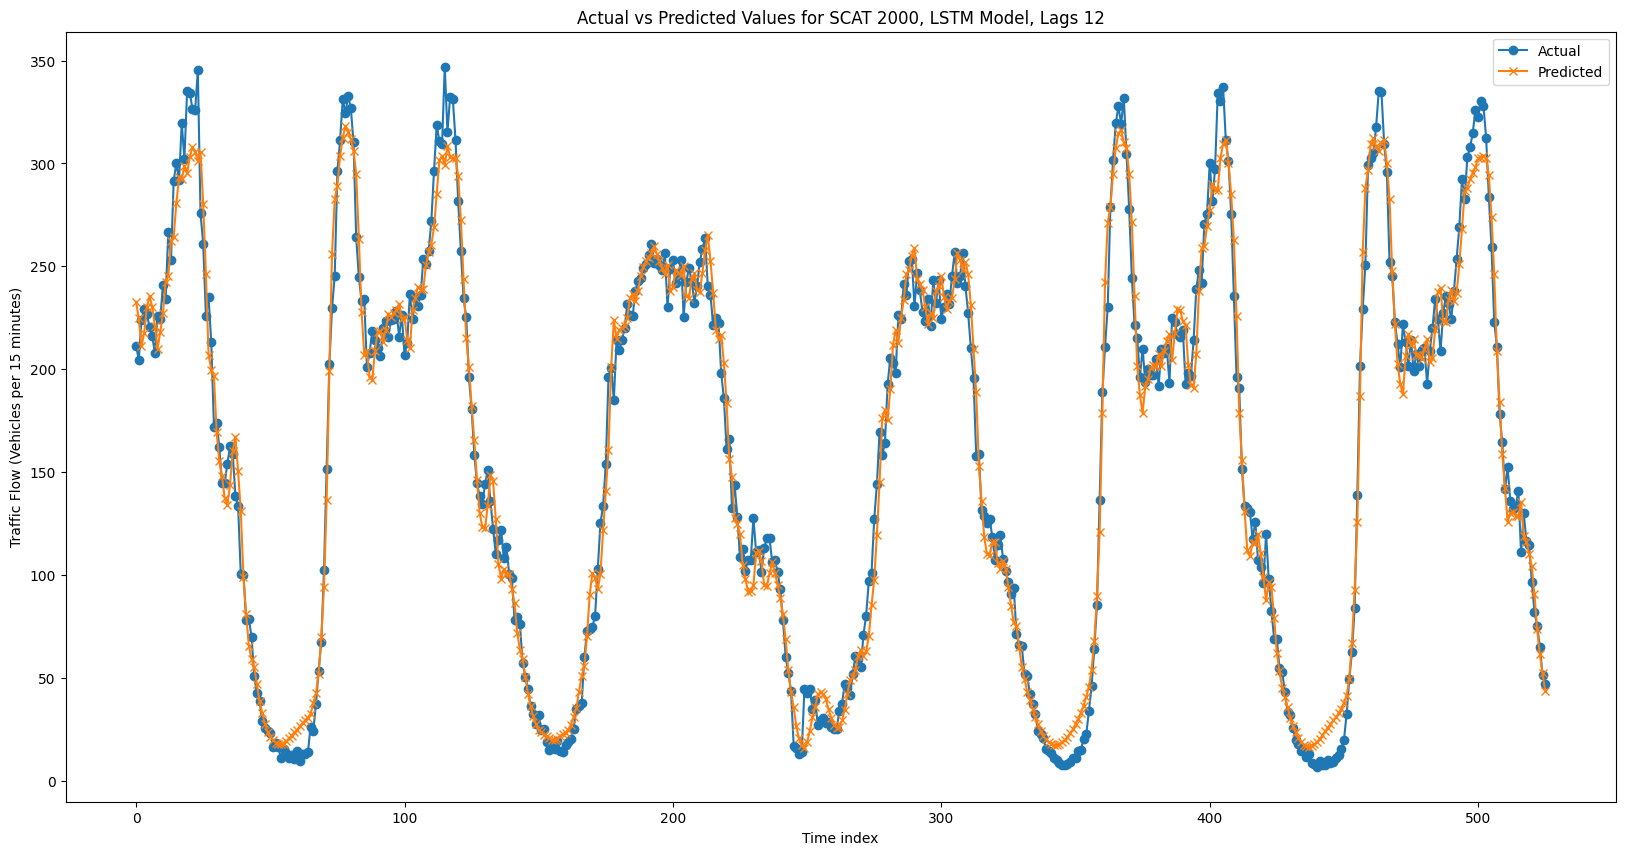

11.20457098057968


In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# PLOT LSTM PREDICTIONS VS ACTUAL VALUES
# Specify which scat to plot
chosen_scat = 2000
plt.figure(figsize=(20, 10))

  # Plot actual values
plt.plot(scaled_true[chosen_scat], label='Actual', marker='o')

# Plot predicted values
plt.plot(scaled_lstm[chosen_scat], label='Predicted', marker='x')

# Add labels and title
plt.xlabel('Time index')
plt.ylabel('Traffic Flow (Vehicles per 15 minutes)')
plt.title('Actual vs Predicted Values for SCAT ' + str(chosen_scat) + ', LSTM Model, Lags 12')

# Add a legend
plt.legend()

plt.savefig(f'images/v2/lstm/{str(chosen_scat)}.png')

# Show the plot
plt.show()

# Print the mean absolute error
print(mean_absolute_error(scaled_true[chosen_scat], scaled_result[chosen_scat]))


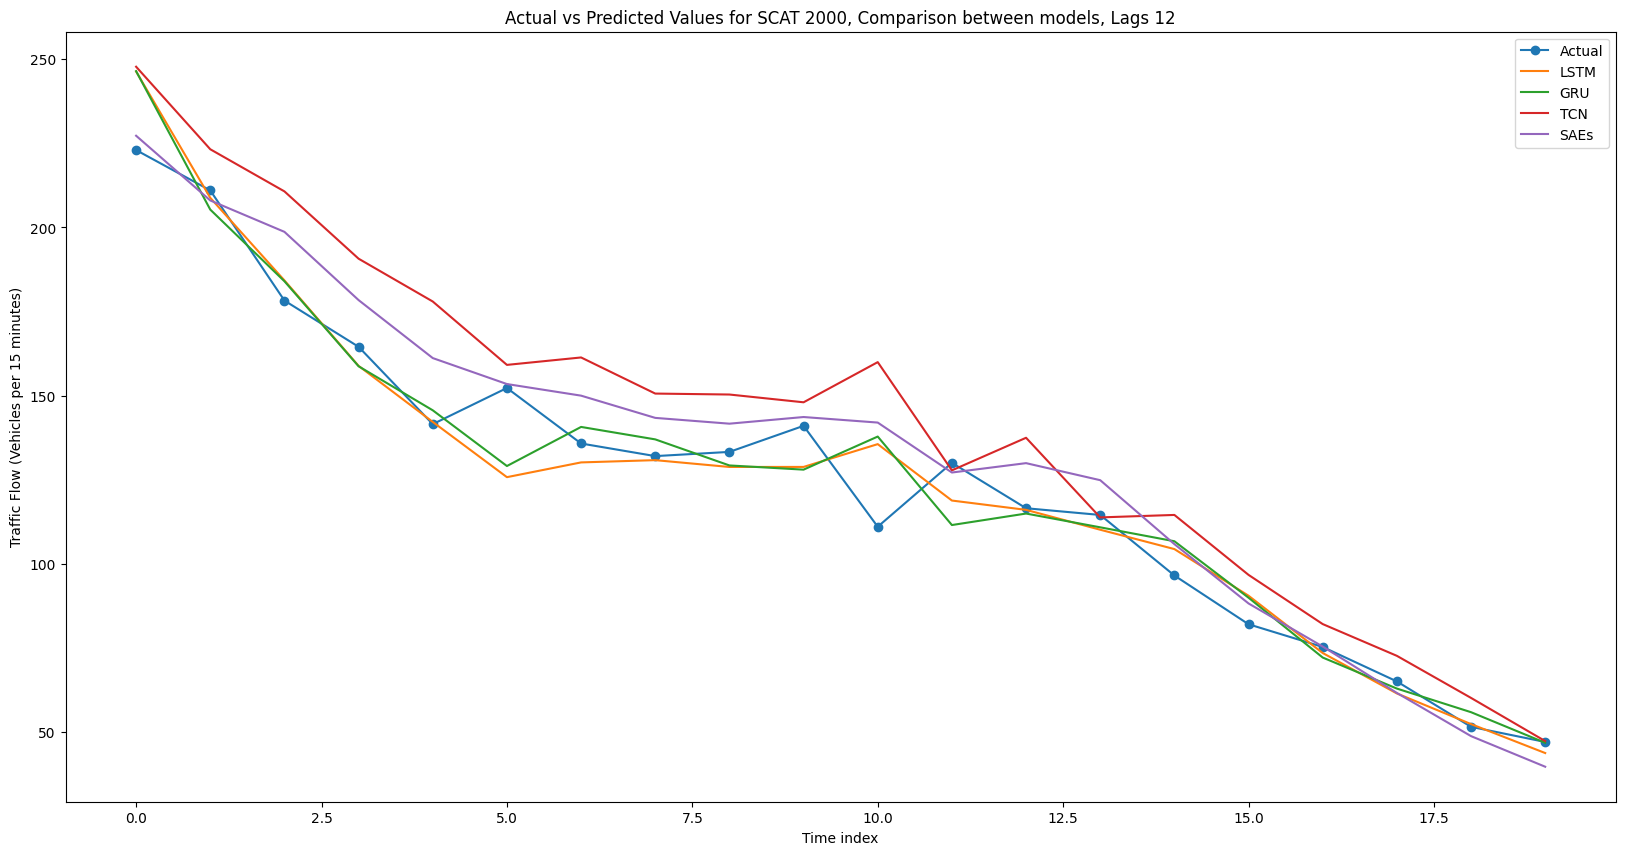

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# PLOT ALL MODELS PREDICTIONS FOR COMPARISON
chosen_scat = 2000

plt.figure(figsize=(20, 10))

  # Plot actual values
plt.plot(scaled_true[chosen_scat][-20:], label='Actual', marker='o')

# Plot predicted values
plt.plot(scaled_lstm[chosen_scat][-20:], label='LSTM')
plt.plot(scaled_gru[chosen_scat][-20:], label='GRU')
plt.plot(scaled_tcn[chosen_scat][-20:], label='TCN')
plt.plot(scaled_sae[chosen_scat][-20:], label='SAEs')

# Add labels and title
plt.xlabel('Time index')
plt.ylabel('Traffic Flow (Vehicles per 15 minutes)')
plt.title('Actual vs Predicted Values for SCAT ' + str(chosen_scat) + ', Comparison between models, Lags 12')

# Add a legend
plt.legend()

# Show the plot
plt.show()